## Projeto 13: Deep Learning - Convolutional Neural Network - Plant Desease Prediction System

- Neste projeto, criaremos uma rede neural convolucional que será capaz de prever se uma planta está sofrendo de alguma doença. 
- Usaremos diferentes camadas e outros hiperparâmetros para construir, treinar e testar este modelo de classificação. estaremos usando tensorflow e Keras para este projeto

Processo de importação de todas as bibliotecas necessárias. Como estamos fazendo um modelo CNN, importaremos todas as camadas necessárias, ativações, otimizadores, etc.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os
from os import listdir
from PIL import Image
from sklearn.preprocessing import label_binarize,  LabelBinarizer
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.utils import to_categorical 

Agora vamos observar algumas das imagens que estão em nosso conjunto de dados. Vamos plotar 12 imagens aqui usando a biblioteca matplotlib.

C:\Users\Sepp-Kali-Linux\AppData\Local\Temp\ipykernel_35332\1762081457.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


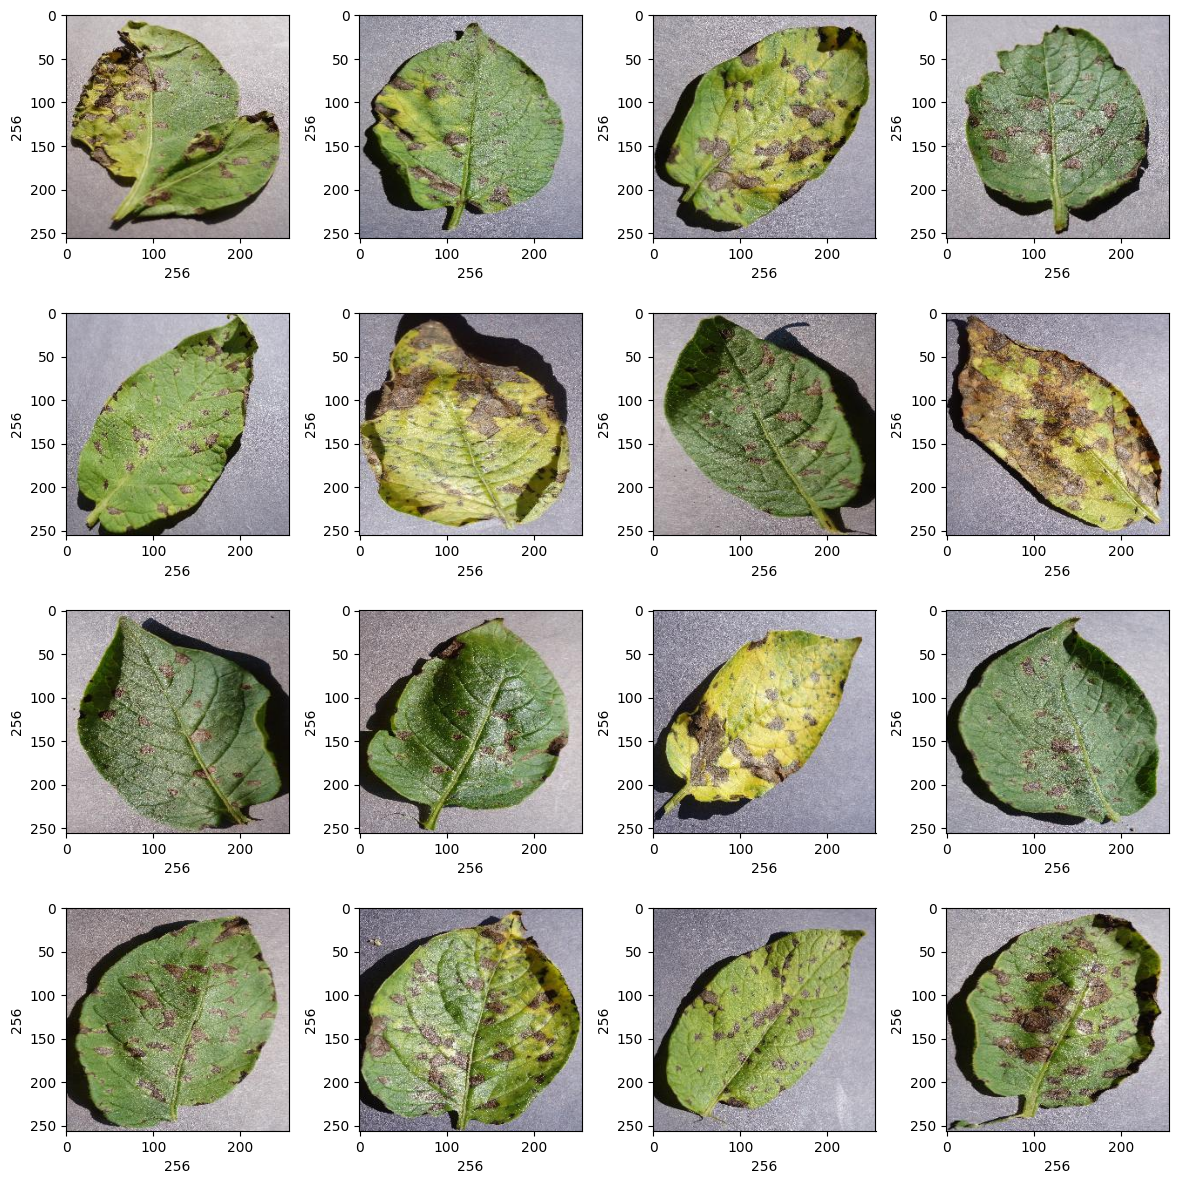

In [10]:
import os
import random
from matplotlib import pyplot as plt
from matplotlib.image import imread

# Substitua o caminho abaixo pelo caminho local no seu computador
path = "C:\\Users\\Sepp-Kali-Linux\\Documents\\Projetos\\Projeto 13 - Plant Disease\\Collab Code\\Data\\Plant_images_pianalytix\\Potato___Early_blight"

# Plotting 12 images to check dataset
plt.figure(figsize=(12,12))

for i in range(1, 17):
    plt.subplot(4, 4, i)
    plt.tight_layout()
    rand_img = imread(os.path.join(path, random.choice(sorted(os.listdir(path)))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize=10)  # width of image
    plt.ylabel(rand_img.shape[0], fontsize=10)  # height of image

plt.show()


Depois de visualizar as imagens, vamos avançar e criar uma função que converterá as imagens em um array numpy. É necessário porque normalizaremos nosso conjunto de dados depois disso.

In [11]:
#Converting Images to array 
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, (256,256))  
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Agora vamos converter todas as imagens em array numpy.

In [12]:
import os
from os import listdir
from matplotlib.image import imread
import numpy as np

def convert_image_to_array(image_path):
    try:
        image = imread(image_path)
        return image
    except Exception as e:
        print(f"Error: {e}")
        return None

# Substitua o caminho abaixo pelo endereço correto no seu computador
dir = "C:\\Users\\Sepp-Kali-Linux\\Documents\\Projetos\\Projeto 13 - Plant Disease\\Collab Code\\Data\\Plant_images_pianalytix"
root_dir = listdir(dir)
image_list, label_list = [], []
all_labels = ['Corn-Common_rust', 'Potato-Early_blight', 'Tomato-Bacterial_spot']
binary_labels = [0, 1, 2]
temp = -1

# Reading and converting image to numpy array
for directory in root_dir:
    plant_image_list = listdir(f"{dir}/{directory}")
    temp += 1
    for files in plant_image_list:
        image_path = f"{dir}/{directory}/{files}"
        image_list.append(convert_image_to_array(image_path))
        label_list.append(binary_labels[temp])

# Convert lists to numpy arrays
image_list = np.array(image_list)
label_list = np.array(label_list)

print("Total number of images in the dataset: ", image_list.shape[0])
print("Number of images in each class: ", np.unique(label_list, return_counts=True))


Total number of images in the dataset:  900
Number of images in each class:  (array([0, 1, 2]), array([300, 300, 300], dtype=int64))


Também observaremos o número de imagens em diferentes classes para ver se o conjunto de dados está balanceado ou não

In [13]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_list).value_counts()
label_counts.head()

0    300
1    300
2    300
Name: count, dtype: int64

Em seguida, observaremos a forma da imagem

In [14]:
image_list[0].shape

(256, 256, 3)

Verificando o número total de imagens que é o comprimento da lista de labels.

In [15]:
label_list = np.array(label_list)
label_list.shape

(900,)

Em seguida, usaremos sklearn train_test_split para dividir o conjunto de dados em dados de teste e treinamento. Aqui, tomei o tamanho do teste como 0,2, então meus dados serão divididos em 80% de treinamento e 20% de dados de teste.

In [16]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 10) 

Agora vamos normalizar o conjunto de dados de nossas imagens. Como os valores de pixel variam de 0 a 255, dividiremos cada pixel da imagem por 255 para normalizar o conjunto de dados.

In [17]:
x_train = np.array(x_train, dtype=np.float16) / 225.0
x_test = np.array(x_test, dtype=np.float16) / 225.0
x_train = x_train.reshape( -1, 256,256,3)
x_test = x_test.reshape( -1, 256,256,3)

In [18]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Em seguida, criaremos uma arquitetura de rede para o modelo. Usamos diferentes tipos de camadas de acordo com suas características, nomeadamente Conv_2d (É usado para criar um kernel convolucional que é convoluído com a camada de entrada para produzir o tensor de saída), max_pooling2d (É uma técnica de downsampling que tira o valor máximo sobre a janela definida pelo poolsize), flatten (achata a entrada e cria uma saída 1D), Dense (a camada densa produz a saída como o produto escalar da entrada e do kernel).

In [19]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same",input_shape=(256,256,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(16, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(8, activation="relu"))
model.add(Dense(3, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 85, 85, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 42, 42, 16)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 28224)             0         
                                                                 
 dense (Dense)               (None, 8)                 2

Ao compilar o modelo, precisamos definir o tipo de perda que será Binary Crossentropy para o nosso modelo, juntamente com isso, também precisamos definir o otimizador e as métricas, respectivamente.

In [20]:
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

Em seguida, dividiremos o conjunto de dados em dados de validação e treinamento.

In [21]:
# Splitting the training data set into training and validation data sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

Ajustar o modelo com os dados e descobrir a precisão em cada época para ver como nosso modelo está aprendendo. Agora vamos treinar nosso modelo em 10 épocas e um tamanho de lote de 128. Você pode tentar usar mais número de épocas para aumentar a precisão, mas aqui podemos ver que o modelo já alcançou uma precisão muito alta, então não precisamos executar isso por mais. Durante cada época, podemos ver o desempenho do modelo, visualizando a precisão do treinamento e da validação.

In [22]:
# Training the model
epochs = 50
batch_size = 128
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (x_val, y_val))

Epoch 1/50
5/5 [==============================] - 44s 6s/step - loss: 1.0490 - accuracy: 0.3247 - val_loss: 0.9449 - val_accuracy: 0.4653
Epoch 2/50
5/5 [==============================] - 27s 5s/step - loss: 0.9100 - accuracy: 0.5451 - val_loss: 0.8265 - val_accuracy: 0.6111
Epoch 3/50
5/5 [==============================] - 26s 5s/step - loss: 0.8137 - accuracy: 0.6111 - val_loss: 0.7512 - val_accuracy: 0.6250
Epoch 4/50
5/5 [==============================] - 27s 5s/step - loss: 0.7487 - accuracy: 0.6233 - val_loss: 0.7010 - val_accuracy: 0.6458
Epoch 5/50
5/5 [==============================] - 23s 5s/step - loss: 0.7005 - accuracy: 0.6389 - val_loss: 0.6685 - val_accuracy: 0.6597
Epoch 6/50
5/5 [==============================] - 22s 4s/step - loss: 0.6661 - accuracy: 0.6580 - val_loss: 0.6325 - val_accuracy: 0.6597
Epoch 7/50
5/5 [==============================] - 23s 4s/step - loss: 0.6345 - accuracy: 0.6528 - val_loss: 0.6003 - val_accuracy: 0.6667
Epoch 8/50
5/5 [==================

Salvando o modelo usando diferentes técnicas.

In [23]:
import os
from keras.models import load_model

# Carregando o modelo
#model = load_model("/content/drive/My Drive/plant_disease.h5")

# Substitua o caminho abaixo pelo diretório correto no seu computador
output_dir = "C:\\Users\\Sepp-Kali-Linux\\Documents\\Projetos\\Projeto 13 - Plant Disease"

# Salvar o modelo em formato h5
model.save(os.path.join(output_dir, "plant_disease.h5"))

# Serialize o modelo para JSON
json_model = model.to_json()

# Salvar a arquitetura do modelo em um arquivo JSON
with open(os.path.join(output_dir, "plant_model.json"), "w") as json_file:
    json_file.write(json_model)

# Salvar os pesos do modelo
model.save_weights(os.path.join(output_dir, "plant_model_weights.h5"))

print("Arquivos salvos com sucesso na pasta:", output_dir)


C:\Users\Sepp-Kali-Linux\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Arquivos salvos com sucesso na pasta: C:\Users\Sepp-Kali-Linux\Documents\Projetos\Projeto 13 - Plant Disease


Em seguida, traçaremos a precisão do modelo para o histórico de treinamento.

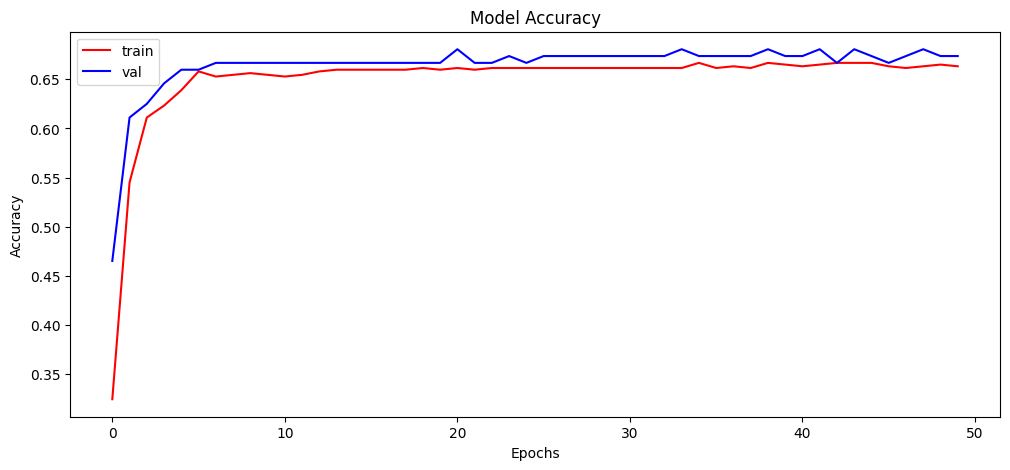

In [24]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

Avaliar o modelo para saber a precisão do modelo.

In [26]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
6/6 [==============================] - 2s 301ms/step - loss: 0.3457 - accuracy: 0.6944
Test Accuracy: 69.44444179534912



Em seguida, usaremos nosso modelo para prever o rótulo do conjunto de dados de teste.

In [27]:
y_pred = model.predict(x_test)

6/6 [==============================] - 2s 334ms/step


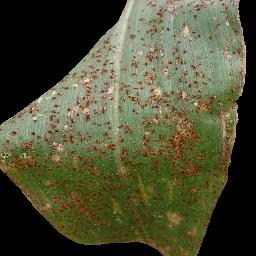

In [37]:
# Plotting image to compare
img = array_to_img(x_test[22])
img

Imprimindo a classificaão original e a classificação prevista.

In [38]:
# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",all_labels[np.argmax(y_test[22])])
print("Predicted : ",all_labels[np.argmax(y_pred[22])])

Originally :  Corn-Common_rust
Predicted :  Corn-Common_rust
